# Group 26: Introduction to Social Data Science (ISDS), exam project 2023

## Can We Predict If a PGA Tour Player Won a Tournament and Their Earnings based on educational background?

This notebook runs the regressions to predict earnings from season 2022 stats. 

## <a id='TOC'>Table of Contents</a>
<ol>
<li><a href='#section 1'>Data Collection: Data Collection: Accessing stats on the PGA Tour website</a></li>
<li><a href='#section_3'>Predicting earnings per tournament based on college background</a></li>
</ol>

## 1. <a id='section_1'>Data Collection: Accessing stats on the PGA Tour website </a>
<a href='#TOC'>Back to table of Contents</a>

### Importing Packages 

In [1]:
import pandas as pd
import requests

### Fetching data via API

In [2]:
def available_stats(category: int):
    """
    Retrieve available statistics within a specific category.
    
    Parameters:
        category (int): The index of the category for which to retrieve statistics.
    
    Returns:
        dict: Information about the statistics within the specified category.
    """
    X_API_KEY = "da2-gsrx5bibzbb4njvhl7t37wqyl4"
    payload = {
        "operationName": "StatDetails",
        "variables": {
            "tourCode": "R",
            "statId": 2,
            "year": 2022,
            "eventQuery": None
        },
        "query": (
            "query StatDetails($tourCode: TourCode!, $statId: String!, $year: Int, $eventQuery: StatDetailEventQuery) {\n"
            "  statDetails(\n"
            "    tourCode: $tourCode\n"
            "    statId: $statId\n"
            "    year: $year\n"
            "    eventQuery: $eventQuery\n"
            "  ) {\n"
            "    tourCode\n"
            "    year\n"
            "    displaySeason\n"
            "    statId\n"
            "    statType\n"
            "    tournamentPills {\n"
            "      tournamentId\n"
            "      displayName\n"
            "    }\n"
            "    yearPills {\n"
            "      year\n"
            "      displaySeason\n"
            "    }\n"
            "    statTitle\n"
            "    statDescription\n"
            "    tourAvg\n"
            "    lastProcessed\n"
            "    statHeaders\n"
            "    statCategories {\n"
            "      category\n"
            "      displayName\n"
            "      subCategories {\n"
            "        displayName\n"
            "        stats {\n"
            "          statId\n"
            "          statTitle\n"
            "        }\n"
            "      }\n"
            "    }\n"
            "    rows {\n"
            "      ... on StatDetailsPlayer {\n"
            "        __typename\n"
            "        playerId\n"
            "        playerName\n"
            "        country\n"
            "        countryFlag\n"
            "        rank\n"
            "        rankDiff\n"
            "        rankChangeTendency\n"
            "        stats {\n"
            "          statName\n"
            "          statValue\n"
            "          color\n"
            "        }\n"
            "      }\n"
            "      ... on StatDetailTourAvg {\n"
            "        __typename\n"
            "        displayName\n"
            "        value\n"
            "      }\n"
            "    }\n"
            "  }\n"
            "}"
        )
    }

    req = requests.post("https://orchestrator.pgatour.com/graphql", json=payload, headers={"x-api-key": X_API_KEY, 'name': 'Simon Knobelauch Hansen', 'email': 'Rfv228@alumni.ku.dk'})
    stats_in_category = req.json()["data"]["statDetails"]["statCategories"][category]
    return stats_in_category

As an example, we can retrieve the available stats in SCORING (category 5). There are 9 categories in total (0-8).

In [3]:
available_stats(category=5)

{'category': 'SCORING',
 'displayName': 'Scoring',
 'subCategories': [{'displayName': 'Strokes Gained - SG',
   'stats': [{'statId': '02675', 'statTitle': 'SG: Total'}]},
  {'displayName': 'Scoring Overall',
   'stats': [{'statId': '120', 'statTitle': 'Scoring Average'},
    {'statId': '108', 'statTitle': 'Scoring Average (Actual)'},
    {'statId': '116', 'statTitle': 'Scoring Average Before Cut'},
    {'statId': '02417', 'statTitle': 'Stroke Differential Field Average'},
    {'statId': '299', 'statTitle': 'Lowest Round'},
    {'statId': '152', 'statTitle': 'Rounds in the 60s'},
    {'statId': '153', 'statTitle': 'Sub-Par Rounds'}]},
  {'displayName': 'Under Par Scoring',
   'stats': [{'statId': '156', 'statTitle': 'Birdie Average'},
    {'statId': '107', 'statTitle': 'Total Birdies'},
    {'statId': '155', 'statTitle': 'Eagles (Holes per)'},
    {'statId': '106', 'statTitle': 'Total Eagles'},
    {'statId': '105', 'statTitle': 'Par Breakers'},
    {'statId': '160', 'statTitle': 'Bounc

We move on to building a function which can retrieve and merge the golf stats we want: 

In [4]:
def get_data(id_list: list):

    """
    Retrieve and merge statistics data based on a list of stat IDs.

    Parameters:
        id_list (list): List of stat IDs to retrieve data for.

    Returns:
        pd.DataFrame: Merged DataFrame containing statistics data.
    """
    
    X_API_KEY = "da2-gsrx5bibzbb4njvhl7t37wqyl4"
    YEAR = 2022 # Change this to the year you want to retrieve data for
    first_stat = True
    
    for stat_id in id_list:
        payload = {
            "operationName": "StatDetails",
            "variables": {
                "tourCode": "R",
                "statId": stat_id,
                "year": YEAR,
                "eventQuery": None
            },
         "query": "query StatDetails($tourCode: TourCode!, $statId: String!, $year: Int, $eventQuery: StatDetailEventQuery) {\n  statDetails(\n    tourCode: $tourCode\n    statId: $statId\n    year: $year\n    eventQuery: $eventQuery\n  ) {\n    tourCode\n    year\n    displaySeason\n    statId\n    statType\n    tournamentPills {\n      tournamentId\n      displayName\n    }\n    yearPills {\n      year\n      displaySeason\n    }\n    statTitle\n    statDescription\n    tourAvg\n    lastProcessed\n    statHeaders\n    statCategories {\n      category\n      displayName\n      subCategories {\n        displayName\n        stats {\n          statId\n          statTitle\n        }\n      }\n    }\n    rows {\n      ... on StatDetailsPlayer {\n        __typename\n        playerId\n        playerName\n        country\n        countryFlag\n        rank\n        rankDiff\n        rankChangeTendency\n        stats {\n          statName\n          statValue\n          color\n        }\n      }\n      ... on StatDetailTourAvg {\n        __typename\n        displayName\n        value\n      }\n    }\n  }\n}"  
      }
        page = requests.post("https://orchestrator.pgatour.com/graphql", json=payload, headers={"x-api-key": X_API_KEY ,'name':'Simon Knobelauch Hansen', 'email':'Rfv228@alumni.ku.dk'})
        page.raise_for_status()
        data = page.json()["data"]["statDetails"]["rows"]
        
        # For the first stat of the loop, we can not merge dataframes, so it is initialized here
        if first_stat:
            df = pd.DataFrame(data)
            if df.empty: # Some stats have no data, giving empty dataframe, which is skipped
                continue
            col_names = ["playerId", "playerName", "country"]
            for col in range(len(page.json()["data"]["statDetails"]["statHeaders"])):
                col_name = page.json()["data"]["statDetails"]["statTitle"]+"("+page.json()["data"]["statDetails"]["statHeaders"][col]+")"
                df[col_name] = df.stats.apply(lambda x: str(x[col]['statValue']).replace(",", "").replace("$", "") if isinstance(x, list) and len(x) > 0 else None)
                col_names.append(col_name)
            df = df[col_names]
            first_stat = False
        
        # Here all the subsequent stats are merged onto the dataframe
        else:
            df_temp = pd.DataFrame(data)
            if df_temp.empty: # Some stats have no data, giving empty dataframe, which is skipped
                continue
            col_names = ["playerId", "playerName", "country"]
            for col in range(len(page.json()["data"]["statDetails"]["statHeaders"])):
                col_name = page.json()["data"]["statDetails"]["statTitle"]+"("+page.json()["data"]["statDetails"]["statHeaders"][col]+")"
                df_temp[col_name] = df_temp.stats.apply(lambda x: str(x[col]['statValue']).replace(",", "").replace("$", "") if isinstance(x, list) and len(x) > 0 else None)
                col_names.append(col_name)
            df_temp = df_temp[col_names]

            df = pd.merge(df, df_temp, left_on=["playerId", "playerName", "country"], right_on=["playerId", "playerName", "country"], how="outer")
            
    return df

Now, define a list of stat IDs that we want to include in our dataset. We provide an example below. Note, the length of the dataframe must equal the number of unique Player IDs to ensure that each row corresponds to one player. 

In [5]:
desired_stats = ["02675", "02567", "02568", "02569", "02564", "101", "130", "402", "014","108", "103", "300",'154', "138", "213"]
df = get_data(id_list=desired_stats)
print("Length of df (%s) should be the amount of unique player ids which is: %s" % (len(df), len(df.playerId.unique())))
print(df.columns)

Length of df (1192) should be the amount of unique player ids which is: 1192
Index(['playerId', 'playerName', 'country', 'SG: Total(Avg)',
       'SG: Total(Total SG:T)', 'SG: Total(Total SG:T2G)',
       'SG: Total(Total SG:P)', 'SG: Total(Measured Rounds)',
       'SG: Off-the-Tee(Avg)', 'SG: Off-the-Tee(Total SG:OTT)',
       'SG: Off-the-Tee(Measured Rounds)', 'SG: Approach the Green(Avg)',
       'SG: Approach the Green(Total SG:APP)',
       'SG: Approach the Green(Measured Rounds)', 'SG: Around-the-Green(Avg)',
       'SG: Around-the-Green(Total SG:ARG)',
       'SG: Around-the-Green(Measured Rounds)', 'SG: Putting(Avg)',
       'SG: Putting(Total SG:Putting)', 'SG: Putting(Measured Rounds)',
       'Driving Distance(Avg)', 'Driving Distance(Total Distance)',
       'Driving Distance(Total Drives)', 'Scrambling(%)',
       'Scrambling(Par or Better)', 'Scrambling(Missed GIR)',
       'Overall Putting Average(Avg)', 'Overall Putting Average(# of Putts)',
       'Overall Putting A

In [6]:
df

,playerId,playerName,country,SG: Total(Avg),SG: Total(Total SG:T),SG: Total(Total SG:T2G),SG: Total(Total SG:P),SG: Total(Measured Rounds),SG: Off-the-Tee(Avg),SG: Off-the-Tee(Total SG:OTT),...,Money per Event Leaders(Money per event),Money per Event Leaders(Total money),Top 10 Finishes(Top 10),Top 10 Finishes(1st),Top 10 Finishes(2nd),Top 10 Finishes(3rd),Hit Fairway Percentage(%),Hit Fairway Percentage(Fairways Hit),Hit Fairway Percentage(Possible Fairways),Hit Fairway Percentage(Relative to Par)
0,28237,Rory McIlroy,Northern Ireland,2.115,109.968,84.208,25.762,52,.771,40.068,...,540910,8654566,10,3,1,1,57.34,410,715,-0.28
1,40098,Matt Fitzpatrick,England,1.792,86.035,65.650,20.385,48,.636,30.505,...,350634,7012672,10,1,1,0,62.52,447,715,-0.20
2,47483,Will Zalatoris,United States,1.767,100.723,100.913,-.188,57,.602,34.290,...,391878,9405082,9,1,3,0,54.53,445,816,-0.29
3,33448,Justin Thomas,United States,1.680,102.492,96.939,5.553,61,.538,32.800,...,325218,6829576,10,1,0,3,54.46,476,874,-0.32
4,46046,Scottie Scheffler,United States,1.677,110.666,97.362,13.304,66,.356,23.482,...,561876,14046910,11,4,4,1,57.55,541,940,-0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,27114,Ben Willman,England,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1188,35709,Jeff Winther,Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1189,50012,Wyatt Worthington II,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190,46615,Alex Wrigley,England,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# List of column names you want to drop
columns_to_drop = ['SG: Off-the-Tee(Measured Rounds)', 'SG: Approach the Green(Measured Rounds)', 'SG: Around-the-Green(Measured Rounds)', 'SG: Putting(Measured Rounds)', 'Scrambling(Par or Better)', 'Overall Putting Average(# of Putts)', 'Overall Putting Average(# of Holes)', 'Scoring Average (Actual)(Total Strokes)', 'Scoring Average (Actual)(Total Rounds)', 'Greens in Regulation Percentage(Greens Hit)', 'Greens in Regulation Percentage(# Holes)', 'Greens in Regulation Percentage(Relative/Par)', 'Top 10 Finishes(1st)', 'Top 10 Finishes(2nd)', 'Top 10 Finishes(3rd)', 'Hit Fairway Percentage(Possible Fairways)', 'Hit Fairway Percentage(Relative to Par)', 'Hit Fairway Percentage(Fairways Hit)', 'Driving Distance(Total Drives)', 'Driving Distance(Total Distance)', 'SG: Total(Total SG:T)', 'SG: Off-the-Tee(Avg)', 'SG: Approach the Green(Avg)', 'SG: Around-the-Green(Avg)']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Replace NaN with 0 in Top 10 
df['Top 10 Finishes(Top 10)'].fillna(0, inplace=True)
df['Top 10 Finishes(Top 10)'] = df['Top 10 Finishes(Top 10)'].astype(int)
df['Scrambling(%)'] = df['Scrambling(%)'].str.rstrip('%').astype(float)
df['Greens in Regulation Percentage(%)'] = df['Greens in Regulation Percentage(%)'].str.rstrip('%').astype(float)
df['Hit Fairway Percentage(%)'] = df['Hit Fairway Percentage(%)'].str.rstrip('%').astype(float)

# Loop through object columns starting from index 3 and try to convert them to integers
for column in df.select_dtypes(include=['object']).iloc[:, 3:].columns:
    df[column] = pd.to_numeric(df[column], errors='coerce').astype('Int64', errors='ignore')

# Drop rows with NaN values
df = df.dropna()

In [8]:
column_types = df.dtypes
column_types

playerId                                     object
playerName                                   object
country                                      object
SG: Total(Avg)                              float64
SG: Total(Total SG:T2G)                     float64
SG: Total(Total SG:P)                       float64
SG: Total(Measured Rounds)                    Int64
SG: Off-the-Tee(Total SG:OTT)               float64
SG: Approach the Green(Total SG:APP)        float64
SG: Around-the-Green(Total SG:ARG)          float64
SG: Putting(Avg)                            float64
SG: Putting(Total SG:Putting)               float64
Driving Distance(Avg)                       float64
Scrambling(%)                               float64
Scrambling(Missed GIR)                        Int64
Overall Putting Average(Avg)                float64
Career Earnings(Money)                        Int64
Scoring Average (Actual)(Avg)               float64
Greens in Regulation Percentage(%)          float64
Victory Lead

In [9]:
df.describe()

,SG: Total(Avg),SG: Total(Total SG:T2G),SG: Total(Total SG:P),SG: Total(Measured Rounds),SG: Off-the-Tee(Total SG:OTT),SG: Approach the Green(Total SG:APP),SG: Around-the-Green(Total SG:ARG),SG: Putting(Avg),SG: Putting(Total SG:Putting),Driving Distance(Avg),...,Scrambling(Missed GIR),Overall Putting Average(Avg),Career Earnings(Money),Scoring Average (Actual)(Avg),Greens in Regulation Percentage(%),Victory Leaders(Victories),Money per Event Leaders(Money per event),Money per Event Leaders(Total money),Top 10 Finishes(Top 10),Hit Fairway Percentage(%)
count,193.000000,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.0,193.000000,193.0,193.000000,193.00000,193.0,193.0,193.0,193.000000,193.000000
mean,0.170057,10.367995,2.489585,59.735751,3.260845,5.255829,1.844197,0.038694,2.489585,300.488083,...,444.917098,1.609083,13821486.326425,70.392021,66.29601,0.238342,86260.901554,2013306.471503,2.611399,60.007513
std,0.693211,37.447647,18.861069,13.512634,20.460289,20.877932,13.654148,0.313563,18.861069,8.677294,...,84.688605,0.023962,13918179.013107,0.612090,2.39817,0.641597,97723.57889,2079022.164757,2.438680,4.979210
min,-1.374000,-87.132000,-63.687000,32.0,-61.380000,-58.174000,-46.628000,-0.951000,-63.687000,277.400000,...,263.0,1.539000,128934.0,68.840000,57.82000,0.0,5272.0,115976.0,0.000000,47.950000
25%,-0.280000,-16.809000,-9.181000,49.0,-8.899000,-6.182000,-6.978000,-0.152000,-9.181000,294.700000,...,381.0,1.593000,3315920.0,70.010000,64.79000,0.0,29470.0,705260.0,1.000000,56.460000
50%,0.142000,5.883000,0.891000,60.0,1.033000,4.818000,2.038000,0.016000,0.891000,300.300000,...,440.0,1.606000,9153099.0,70.390000,66.47000,0.0,52098.0,1303036.0,2.000000,60.120000
75%,0.554000,33.794000,13.304000,70.0,17.137000,17.787000,11.194000,0.241000,13.304000,306.900000,...,507.0,1.626000,19268517.0,70.790000,67.92000,0.0,101805.0,2558440.0,4.000000,63.030000
max,2.115000,100.913000,71.169000,95.0,64.001000,61.050000,31.131000,0.853000,71.169000,321.400000,...,682.0,1.675000,66174549.0,72.030000,72.29000,4.0,561876.0,14046910.0,12.000000,74.750000


Next up, we want to access the biographies of each player available on the website. We then want to merge the information retrieved from the bios on to the dataframe containing the desired stats for each player. 

In [10]:
# API key for authentication
X_API_KEY = "da2-gsrx5bibzbb4njvhl7t37wqyl4"

# Define the payload for the GraphQL query
payload = {
    "operationName": "PlayerDirectory",
    "variables": {
        "tourCode": "R"
    },
    "query": """
        query PlayerDirectory($tourCode: TourCode!, $active: Boolean) {
            playerDirectory(tourCode: $tourCode, active: $active) {
                tourCode
                players {
                    id
                    isActive
                    firstName
                    lastName
                    shortName
                    displayName
                    alphaSort
                    country
                    countryFlag
                    headshot
                    playerBio {
                        id
                        age
                        education
                        turnedPro
                    }
                }
            }
        }
    """
}

# Send a POST request to the GraphQL API
req = requests.post(
    "https://orchestrator.pgatour.com/graphql",
    json=payload,
    headers={"x-api-key": X_API_KEY}
)

# Extract player data from the API response and create a DataFrame
df_player_bio = pd.DataFrame(req.json()["data"]["playerDirectory"])

# Extract playerBio information from the DataFrame
player_bio_list = []
for i in range(len(df_player_bio)):
    player_bio_list.append(df_player_bio.players.iloc[i]["playerBio"])
df_player_bio = pd.DataFrame(player_bio_list)

# Merge playerBio data with existing DataFrame using playerId as the key
df = pd.merge(df, df_player_bio, left_on="playerId", right_on="id", how="left")
df.drop(columns=['id'], inplace=True)

In [11]:
df['age'] = df['age'].astype(float)
df['turnedPro'] = df['turnedPro'].astype(float)
df['Winner_dummy'] = df['Victory Leaders(Victories)'].apply(lambda x: 1 if x > 0 else 0) #Winner dummy
df['Career Earnings(Money)'] = df['Career Earnings(Money)'].astype(float)
df['Money per Event Leaders(Total money)'] = df['Money per Event Leaders(Total money)'].astype(float)

# Convert specific non-values to NaN in the "Education" column
non_values = ['non', 'na', 'n/a', 'unknown', 'None']  # List of non-values to convert
df['education'] = df['education'].apply(lambda x: np.nan if x in non_values else x)

# Replace NaN values with "Outside the US" in the "Education" column
df['education'] = df['education'].fillna('outside the US')

# Convert specific non-values to NaN in the "Education" column
non_values = ['non', 'na', 'n/a', 'unknown', 'None']  # List of non-values to convert
df['turnedPro'] = df['turnedPro'].apply(lambda x: np.nan if x in non_values else x)

# Replace NaN values with "Outside the US" in the "Education" column
df['turnedPro'] = df['turnedPro'].fillna('Amateur')
df.drop(columns=['turnedPro'], inplace=True)

In [12]:
df.describe()

,SG: Total(Avg),SG: Total(Total SG:T2G),SG: Total(Total SG:P),SG: Total(Measured Rounds),SG: Off-the-Tee(Total SG:OTT),SG: Approach the Green(Total SG:APP),SG: Around-the-Green(Total SG:ARG),SG: Putting(Avg),SG: Putting(Total SG:Putting),Driving Distance(Avg),...,Career Earnings(Money),Scoring Average (Actual)(Avg),Greens in Regulation Percentage(%),Victory Leaders(Victories),Money per Event Leaders(Money per event),Money per Event Leaders(Total money),Top 10 Finishes(Top 10),Hit Fairway Percentage(%),age,Winner_dummy
count,193.000000,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,1.930000e+02,193.000000,193.00000,193.0,193.0,1.930000e+02,193.000000,193.000000,192.000000,193.000000
mean,0.170057,10.367995,2.489585,59.735751,3.260845,5.255829,1.844197,0.038694,2.489585,300.488083,...,1.382149e+07,70.392021,66.29601,0.238342,86260.901554,2.013306e+06,2.611399,60.007513,34.208333,0.160622
std,0.693211,37.447647,18.861069,13.512634,20.460289,20.877932,13.654148,0.313563,18.861069,8.677294,...,1.391818e+07,0.612090,2.39817,0.641597,97723.57889,2.079022e+06,2.438680,4.979210,5.919913,0.368137
min,-1.374000,-87.132000,-63.687000,32.0,-61.380000,-58.174000,-46.628000,-0.951000,-63.687000,277.400000,...,1.289340e+05,68.840000,57.82000,0.0,5272.0,1.159760e+05,0.000000,47.950000,24.000000,0.000000
25%,-0.280000,-16.809000,-9.181000,49.0,-8.899000,-6.182000,-6.978000,-0.152000,-9.181000,294.700000,...,3.315920e+06,70.010000,64.79000,0.0,29470.0,7.052600e+05,1.000000,56.460000,30.000000,0.000000
50%,0.142000,5.883000,0.891000,60.0,1.033000,4.818000,2.038000,0.016000,0.891000,300.300000,...,9.153099e+06,70.390000,66.47000,0.0,52098.0,1.303036e+06,2.000000,60.120000,33.000000,0.000000
75%,0.554000,33.794000,13.304000,70.0,17.137000,17.787000,11.194000,0.241000,13.304000,306.900000,...,1.926852e+07,70.790000,67.92000,0.0,101805.0,2.558440e+06,4.000000,63.030000,38.000000,0.000000
max,2.115000,100.913000,71.169000,95.0,64.001000,61.050000,31.131000,0.853000,71.169000,321.400000,...,6.617455e+07,72.030000,72.29000,4.0,561876.0,1.404691e+07,12.000000,74.750000,50.000000,1.000000


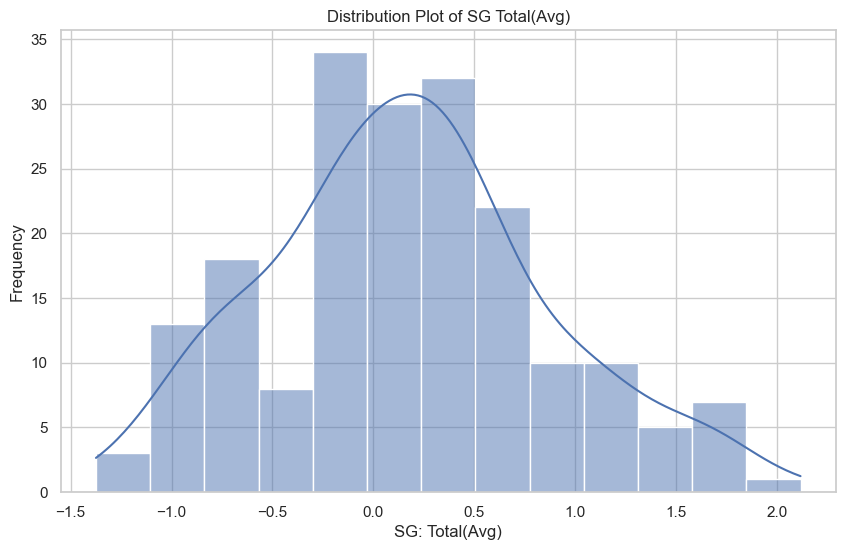

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set style for the plots (optional)
sns.set(style="whitegrid")

# Create a distribution plot for SG Total(Avg)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

sns.histplot(data=df, x="SG: Total(Avg)", kde=True)  # Create a histogram with KDE

plt.title("Distribution Plot of SG Total(Avg)")
plt.xlabel("SG: Total(Avg)")
plt.ylabel("Frequency")
plt.show()

C:\Users\Illum\AppData\Local\Temp\ipykernel_35400\4280832914.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


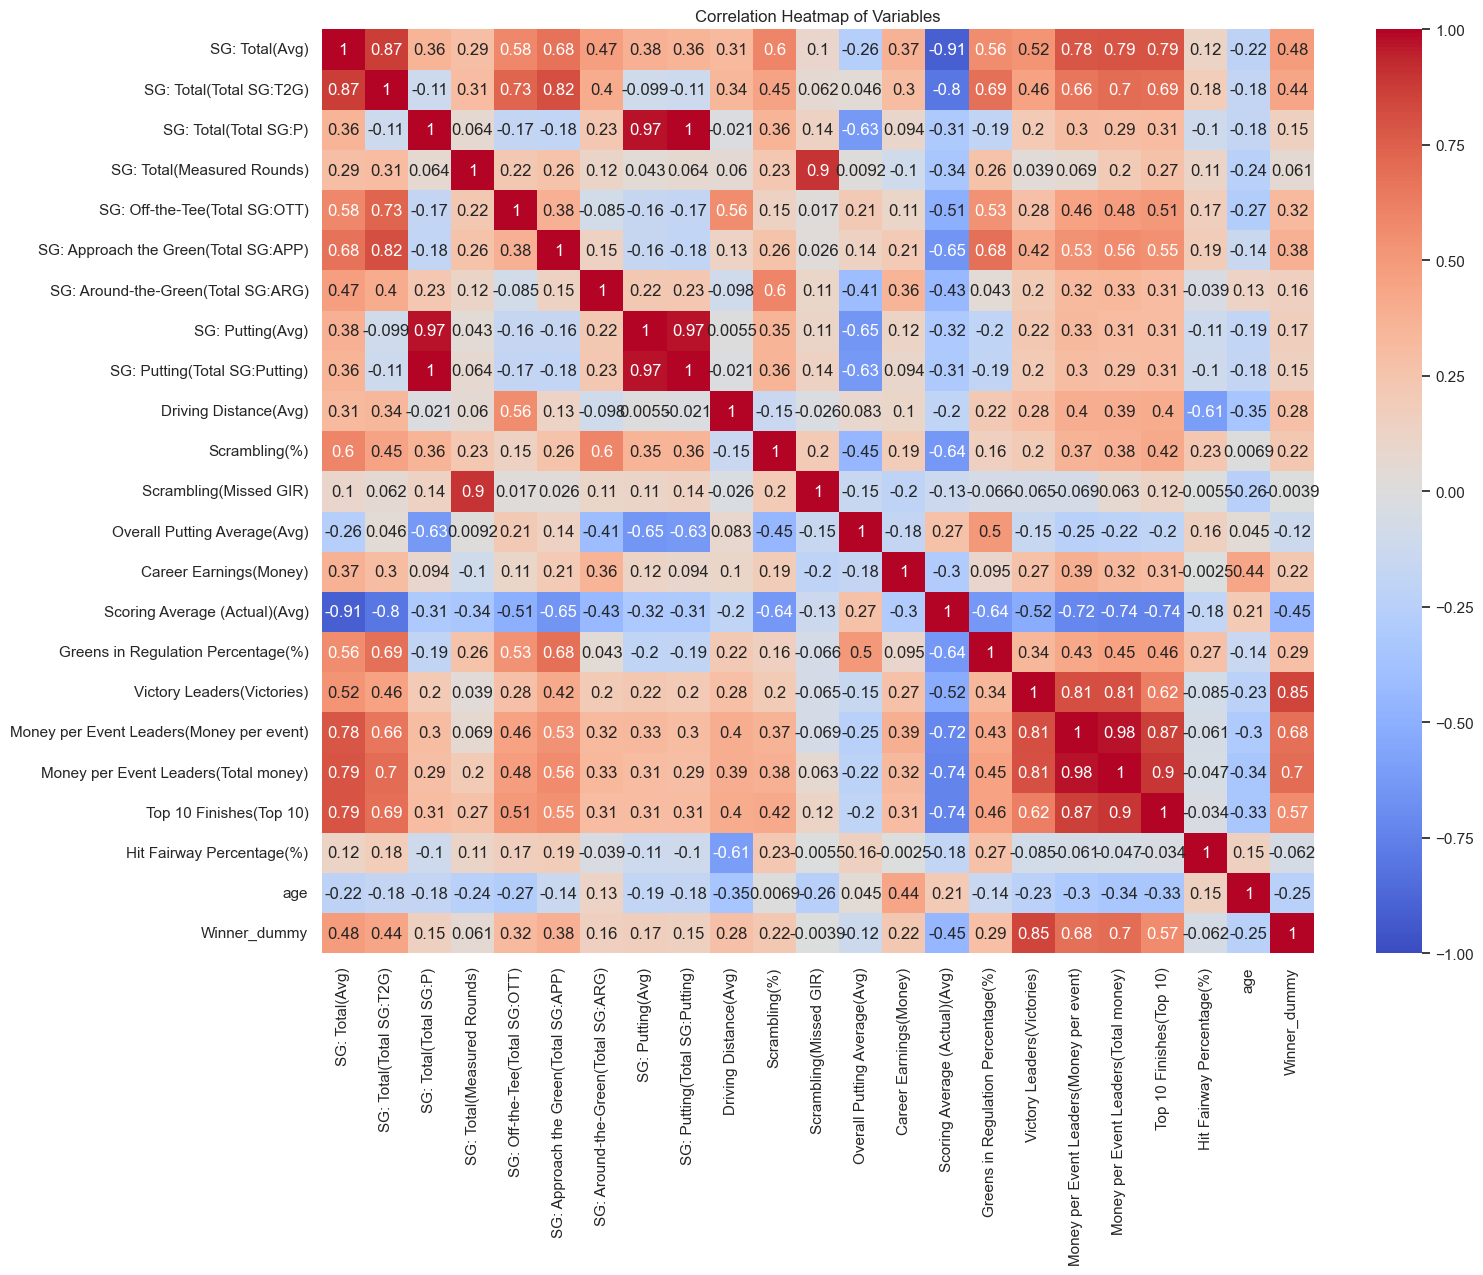

In [14]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the figure
plt.figure(figsize=(16, 12))  # Adjust the figure size as needed

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title("Correlation Heatmap of Variables")
plt.show()

In [15]:
df.corr()['Victory Leaders(Victories)']

C:\Users\Illum\AppData\Local\Temp\ipykernel_35400\4206621012.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['Victory Leaders(Victories)']


SG: Total(Avg)                              0.524559
SG: Total(Total SG:T2G)                     0.457609
SG: Total(Total SG:P)                       0.203989
SG: Total(Measured Rounds)                  0.038542
SG: Off-the-Tee(Total SG:OTT)               0.279286
SG: Approach the Green(Total SG:APP)        0.415657
SG: Around-the-Green(Total SG:ARG)          0.200621
SG: Putting(Avg)                            0.220936
SG: Putting(Total SG:Putting)               0.203989
Driving Distance(Avg)                       0.283881
Scrambling(%)                               0.202960
Scrambling(Missed GIR)                     -0.064815
Overall Putting Average(Avg)               -0.153065
Career Earnings(Money)                      0.271798
Scoring Average (Actual)(Avg)              -0.515945
Greens in Regulation Percentage(%)          0.338713
Victory Leaders(Victories)                  1.000000
Money per Event Leaders(Money per event)    0.814358
Money per Event Leaders(Total money)        0.

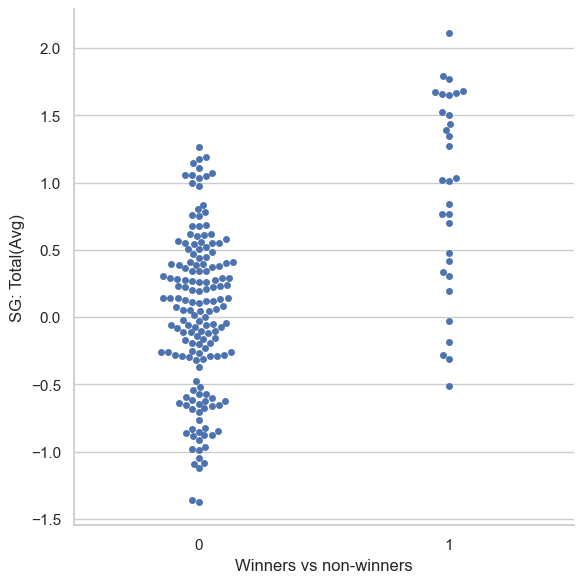

In [16]:
ax = sns.catplot(x="Winner_dummy", y="SG: Total(Avg)", kind="swarm", data=df, height=6)
ax.set(xlabel='Winners vs non-winners', ylabel='SG: Total(Avg)');

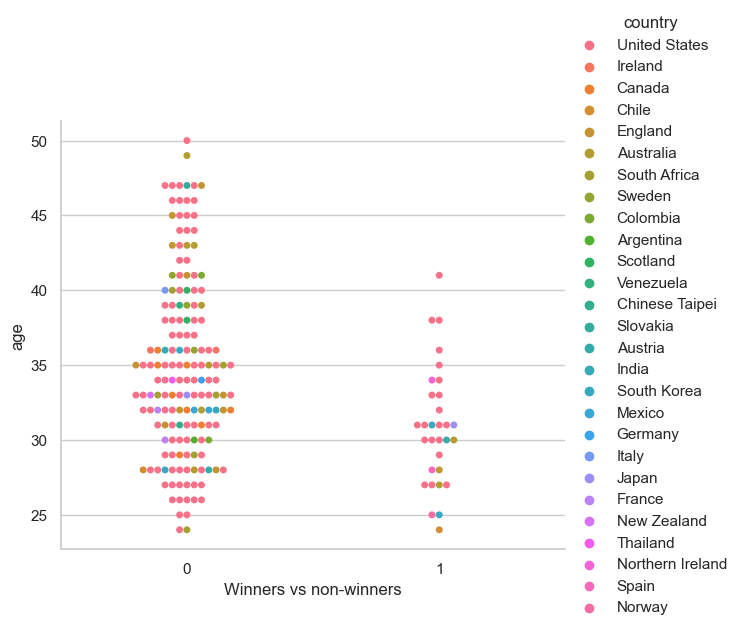

In [17]:
ax = sns.catplot(x="Winner_dummy", y="age", kind="swarm", hue="country", data=df, height=6)
ax.set(xlabel='Winners vs non-winners', ylabel='age');

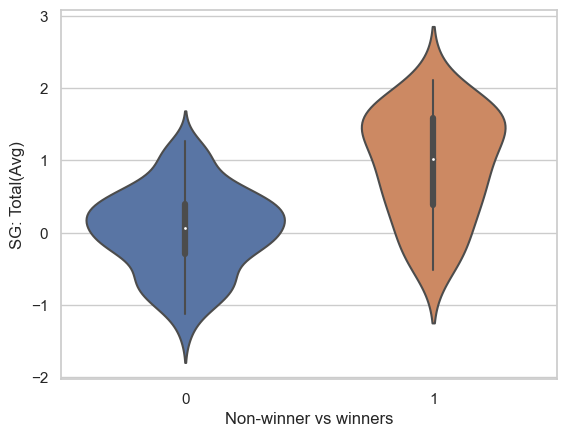

In [18]:
ax = sns.violinplot(x='Winner_dummy', y='SG: Total(Avg)', data=df)
ax.set(xlabel='Non-winner vs winners', ylabel='SG: Total(Avg)');

In [19]:
print(df['SG: Total(Avg)'].dtype)
print(df['Career Earnings(Money)'].dtype)

float64
float64


<Figure size 800x600 with 0 Axes>

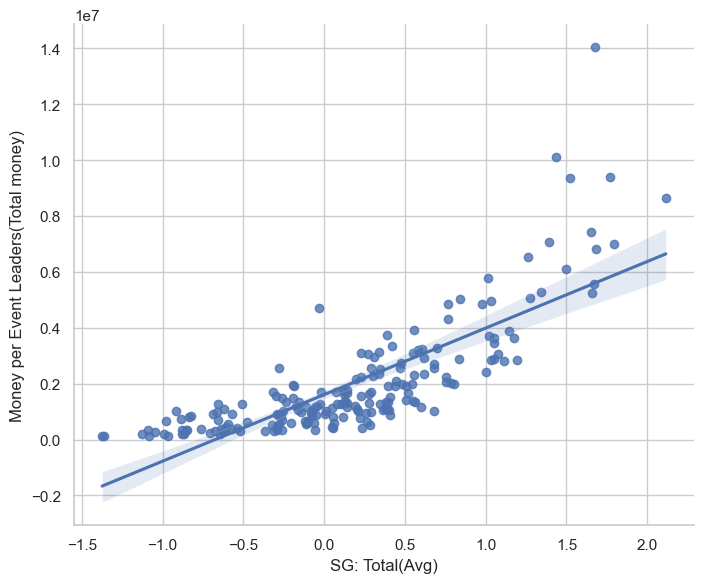

In [20]:
# Set the size of the plot
plt.figure(figsize=(8, 6))  # Adjust width and height as needed

# Create the lmplot with adjusted size
ax = sns.lmplot(x='SG: Total(Avg)', y='Money per Event Leaders(Total money)', data=df, height=6, aspect=1.2)

# Set labels for the plot
ax.set(xlabel='SG: Total(Avg)', ylabel='Money per Event Leaders(Total money)')

# Show the plot
plt.show()

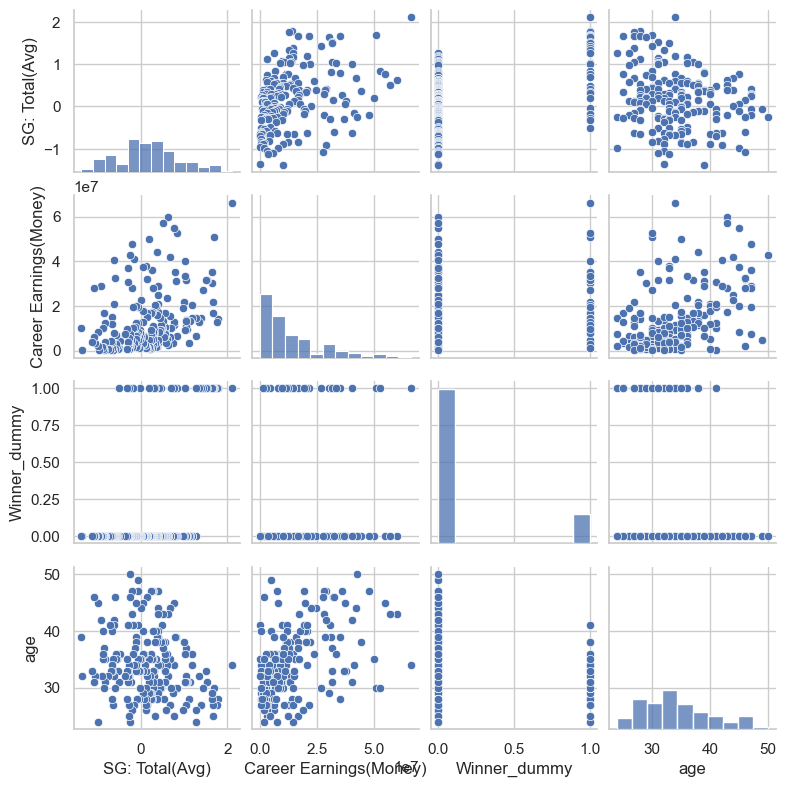

In [21]:
sns.pairplot(df, vars = ['SG: Total(Avg)', 'Career Earnings(Money)', 'Winner_dummy', 'age'] ,height=2); # make hist and scatter for all numeric variables

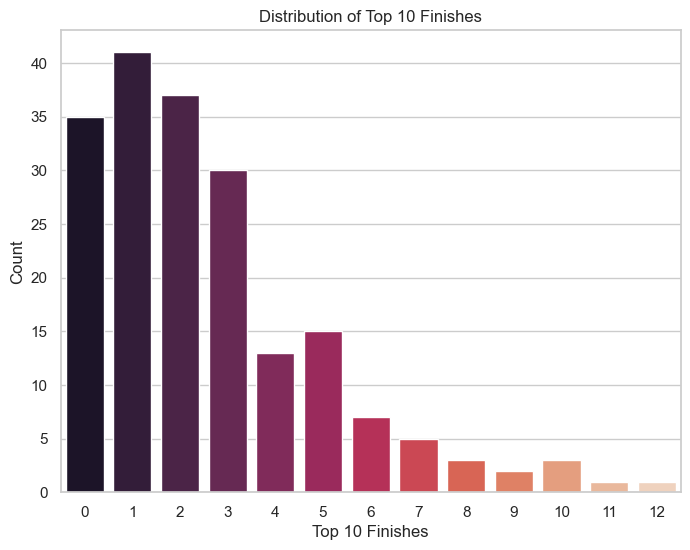

In [22]:
# Set the size of the plot
plt.figure(figsize=(8, 6))  # Adjust width and height as needed

# Create a bar plot for distribution of top ten finishes
ax = sns.countplot(x='Top 10 Finishes(Top 10)', data=df, palette='rocket')

# Set labels for the plot
ax.set(xlabel='Top 10 Finishes', ylabel='Count')
plt.title('Distribution of Top 10 Finishes')

# Show the plot
plt.show()

## 2. <a id='section_3'>Predicting earnings per event based on college background</a>
<a href='#TOC'>Back to table of Contents</a>

### Importing Packages 

In [23]:
# Import packages relevant for the this seciton 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Preparing dataframe for regression

Make dataframe and define features (X) and target (y)

In [24]:
# Create a new DataFrame
earning_df = df.copy()

# Remove rows with NaN values
earning_df.dropna(inplace=True)

# Y value for machine learning is the Money column
Y = earning_df['Money per Event Leaders(Money per event)']

# Removing the specified columns from the DataFrame
columns_to_drop = ['Winner_dummy', 'playerId', 'playerName', 'country', 'education', 'Victory Leaders(Victories)', 'Money per Event Leaders(Money per event)', 'Career Earnings(Money)', 'Money per Event Leaders(Total money)', 'Top 10 Finishes(Top 10)', 'SG: Total(Total SG:P)', 'Scrambling(Missed GIR)']
X = earning_df.drop(columns=columns_to_drop, axis=1)

### Setting up a linear regression function 

Making a function that partitions data intro training and test data and then fit the model 

In [25]:
def linear_reg(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 10)
    clf = LinearRegression().fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print('R-Squared on training set: {:.3f}'
          .format(clf.score(X_train, y_train)))
    print('R-Squared on test set {:.3f}'
          .format(clf.score(X_test, y_test)))
    
    print('linear model coeff (w):\n{}'
         .format(clf.coef_))
    print('linear model intercept (b): {:.3f}'
         .format(clf.intercept_))

### Defining linear regression with regularization

In [26]:
# Suppress the FutureWarning since I have tried to identify any issues in the data regarding non numeric values.
warnings.simplefilter(action='ignore', category=FutureWarning)

def linear_reg(X, Y, regularization='none', alpha=1.0):
    # Convert any non-numeric data to numeric, handling errors with 'coerce'
    X = X.apply(pd.to_numeric, errors='coerce')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10)
    
    if regularization == 'none':
        clf = LinearRegression().fit(X_train, y_train)
    elif regularization == 'lasso':
        clf = Lasso(alpha=alpha, max_iter=100000000).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    r2_train = clf.score(X_train, y_train)
    r2_test = clf.score(X_test, y_test)
    
    print('R-Squared on training set: {:.3f}'.format(r2_train))
    print('R-Squared on test set: {:.3f}'.format(r2_test))
    
    if regularization == 'none':
        print('linear model coeff (w):\n{}'.format(clf.coef_))
        print('linear model intercept (b): {:.3f}'.format(clf.intercept_))
    elif regularization == 'lasso':
        print('lasso model coeff (w):\n{}'.format(clf.coef_))
        print('lasso model intercept (b): {:.3f}'.format(clf.intercept_))

Now, you can use the modified X and Y in your linear_reg function as before

In [27]:
# Run regression
linear_reg(X, Y)  # Without regularization

R-Squared on training set: 0.710
R-Squared on test set: 0.645
linear model coeff (w):
[ 64876.98195187  71291.38608977  -1229.31453176 -71580.74596324
 -70787.28251885 -70995.46509581 -59710.53244605   1058.12938794
   2903.89295485  -2724.12415225 -64332.7175997  -45871.70303529
  -1328.5706998    1048.68997685  -1126.12028337]
linear model intercept (b): 2826075.393


In [28]:
# Run regression 
linear_reg(X, Y, regularization='lasso')  # With Lasso regularization

R-Squared on training set: 0.710
R-Squared on test set: 0.645
lasso model coeff (w):
[ 64431.81147353  70657.62831082  -1231.05429883 -70944.25121024
 -70147.80192398 -70355.32716899 -59004.39373494   1054.89635418
   2909.15522172  -2722.69137843 -48635.71681496 -46559.67700355
  -1485.66805015   1052.98668356  -1125.53175571]
lasso model intercept (b): 2857831.994


### Introducing polynomial features 

In [29]:
# Creating a Polynomial Feature to improve R-Squared
poly = PolynomialFeatures(2)
poly = poly.fit(X)
poly_earning = poly.transform(X)
print(poly_earning.shape)

# Creating a DataFrame with the polynomial features 
poly_earning = pd.DataFrame(poly_earning, columns = poly.get_feature_names(X.columns))

(192, 136)


Run regression

In [30]:
linear_reg(poly_earning, Y)

R-Squared on training set: 0.954
R-Squared on test set: -6.361
linear model coeff (w):
[-1.90326110e+14  1.28560841e+08  9.64914564e+07  9.02843630e+05
 -9.63222914e+07 -9.58569581e+07 -9.72334010e+07 -1.02787264e+08
  2.07331187e+06 -2.09138454e+06 -8.70293809e+05 -1.06183814e+08
  3.41229638e+07  1.27338144e+06 -1.29533396e+06 -1.29988739e+06
 -1.57825072e+06  7.37224101e+05 -1.64133831e+06 -6.95101668e+05
 -6.91054187e+05 -7.18441721e+05 -3.05150129e+06  2.52155255e+05
 -6.51718896e+04  2.17636350e+05  2.85359827e+07 -1.91706601e+06
 -4.11928736e+05 -8.70972837e+04  1.75981327e+04 -7.69899834e+06
 -4.57145646e+05  1.52943734e+07  1.52991982e+07  1.62872177e+07
 -4.61935912e+07  1.06405229e+06  6.84394599e+04 -3.14711493e+06
 -1.00043887e+07 -5.47210793e+05  2.22241393e+06  5.83274896e+05
 -9.54644132e+05  1.63152278e+02  4.57744174e+05  4.57426328e+05
  4.57439538e+05 -1.31680664e+05 -5.23680568e+02 -7.64967235e+02
 -8.27368787e+00  1.13370143e+05 -8.90986125e+03 -3.27532031e+03
 -6

Polynomial regression with ridge regularization

In [31]:
def linear_reg_ridge(X, Y, al):
    X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                   random_state = 10)
    clf = Ridge(alpha = al).fit(X_train, y_train)

    print('(poly deg 2 + ridge) R-squared score (training): {:.3f}'
         .format(clf.score(X_train, y_train)))
    print('(poly deg 2 + ridge) R-squared score (test): {:.3f}'
         .format(clf.score(X_test, y_test)))
    
    print('(poly deg 2 + ridge) linear model coeff (w):\n{}'
         .format(clf.coef_))
    print('(poly deg 2 + ridge) linear model intercept (b): {:.3f}'
         .format(clf.intercept_))

In [32]:
linear_reg_ridge(poly_earning, Y, al = 1)

(poly deg 2 + ridge) R-squared score (training): 0.938
(poly deg 2 + ridge) R-squared score (test): 0.664
(poly deg 2 + ridge) linear model coeff (w):
[     0.            358.54570239  15361.66066326    -79.45870711
  11818.21484624   4988.75661359  -1510.8818425     -54.80925291
  -2048.26515618   7580.96869076   -638.75432797     59.60045525
   -230.90517601   2549.91936699    225.1454566   -5323.45390766
  -3698.50660287   -402.31926061  12109.63247402   3285.42477055
   -456.64004455  -3319.33571738  -1967.9922809    -393.68914525
  -5873.95711101  25602.97655097   -186.21365533   4485.43633416
   6352.18494179  -9750.90108077   5179.73939002  -1242.20863472
  -5592.64414409  -5105.98622794  -2683.31712631  10450.15125038
   1458.76990363   5955.04867006   1666.83417958    979.70665536
  -9255.55509635   1082.86812201   1638.50919443    893.55815723
   3060.16924816     25.62920394   5649.42562593   5610.57267201
   5646.01671096  -2738.00762541   -100.5166971    -150.78090492
    

In [33]:
linear_reg_ridge(poly_earning, Y, al = 100)

(poly deg 2 + ridge) R-squared score (training): 0.923
(poly deg 2 + ridge) R-squared score (test): 0.683
(poly deg 2 + ridge) linear model coeff (w):
[ 0.00000000e+00  9.39325037e+00  5.00243317e+02  2.16724126e+00
  3.27981496e+02  1.96776523e+02 -3.00908050e+01 -1.52532126e+00
 -2.21380999e+01  1.45483251e+02  8.03040149e+00  2.00435645e+00
 -6.19321417e+00  1.34494342e+01  2.62247951e+01 -5.85137825e+01
  4.66688320e+01  4.18416927e+02  4.55300229e+02  8.84477950e+02
 -3.08095423e+02 -1.40848983e+02  3.02170282e+01  1.29499828e+03
 -2.34317008e+02  1.32879155e+03 -2.46736346e+01 -6.80153221e+01
  1.93260584e+02 -2.64136147e+01  7.23311487e+02 -5.50974719e+02
 -1.18185591e+01  2.66251331e+02  1.48852112e+02  6.84914968e+02
  2.47677316e+01  1.10420562e+02  3.36056653e+02  1.01576724e+02
 -9.09484827e+02  7.14212768e+01  2.24190372e+02 -8.65212246e-01
  6.35999061e+01  1.80882238e+01  3.48002385e+01  1.31621428e+01
  5.22456250e+01 -6.78935758e-03 -4.67534243e+01 -1.08320173e+02
 -1.

### Cross validation 

In [34]:
from sklearn.model_selection import cross_val_score

def cross_val(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 10)
    clf = Ridge(alpha=100).fit(X_train, y_train)
    scores = cross_val_score(clf, X, Y, cv=5)
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print(scores)

In [35]:
cross_val(poly_earning, Y)

Accuracy: -5.35 (+/- 17.08)
[  0.17465801  -0.84574693  -1.73848956  -1.99517766 -22.36155879]


### Fetching the regression output for use in the project 

In [36]:
def find_earning_with_names(X, Y, education):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10)
    clf = Ridge().fit(X_train, y_train)
    y_pred = clf.predict(X)
    y_pred = pd.Series(y_pred)

    pred_data = pd.concat([X, y_pred], axis=1)
    pred_name = pd.concat([pred_data, df[['education', 'playerName']]], axis=1)

    selected_earnings = pred_name.loc[pred_name['education'] == education]
    return selected_earnings  # Assuming the column name for target variable is 'Y'

education_category = "outside the US"
mean_predicted_earning = find_earning_with_names(X=poly_earning, Y=Y, education=education_category)
print(f"Mean predicted earning for education '{education_category}': {mean_predicted_earning}")

Mean predicted earning for education 'outside the US':        1  SG: Total(Avg)  SG: Total(Total SG:T2G)  SG: Total(Measured Rounds)  \
0    1.0           2.115                   84.208                        52.0   
9    1.0           1.499                   99.974                        71.0   
10   1.0           1.433                   42.601                        49.0   
13   1.0           1.274                   77.447                        58.0   
22   1.0           1.050                   27.002                        40.0   
23   1.0           1.034                   14.026                        48.0   
32   1.0           0.784                   17.477                        63.0   
36   1.0           0.753                    5.516                        55.0   
51   1.0           0.542                   33.892                        76.0   
54   1.0           0.505                    2.083                        38.0   
58   1.0           0.448                   32.869     

In [37]:
# Calculate the mean
mean_money_per_event = df[df['education'] == 'outside the US']['Money per Event Leaders(Money per event)'].mean()

print("Mean of actual Money per Event:", mean_money_per_event)

mean_predicted_earning = mean_predicted_earning[mean_predicted_earning['education'] == 'outside the US'][0.].mean()

print("Mean predicted earnings:", mean_predicted_earning)

Mean of actual Money per Event: 120673.08333333333
Mean predicted earnings: 118690.9502925608
